# What is NumPy

Numpy is Python library for scientific computing. It’s main object is the homogeneous multidimensional array. It is a table of elements, all of the same type, indexed by a tuple of positive integers. 

## Why numpy arrays can accelerate your applications?

A NumPy ndarray array is described by metadata: number of dimensions, shape, data type, and so on, and the actual data stored in it. The data is stored in a homogeneous and contiguous blocks of memory, at a particular address in system memory (Random Access Memory, or RAM). This is the main difference with a pure Python data structures, in which the items are scattered across the system memory. This aspect is the critical feature that makes NumPy arrays efficient.

## Why is this so important? 

Array computations can be implemented efficiently in a low-level language like C (and a large part of NumPy is actually written in C). Knowing the address of the memory block and the data type, it is just simple arithmetic to loop over all items, for example. There would be a significant overhead to do that in Python with a list.

Spatial locality in memory access patterns results in significant performance gains, notably thanks to the CPU cache. 

Data elements are stored contiguously in memory, so that NumPy can take advantage of vectorized instructions on modern CPUs, like Intel's SSE and AVX, AMD's XOP, and so on. 

NumPy can be linked to highly optimized linear algebra libraries like BLAS and LAPACK, for example through the Intel Math Kernel Library (MKL). A few specific matrix computations may also be multithreaded, taking advantage of the power of modern multicore processors.

In conclusion, storing data in a contiguous blocks of memory ensures that the architecture of modern CPUs is used optimally, in terms of memory access patterns, CPU cache, and vectorized instructions.


# Motivation

* Provide a uniform interface for handling numerical structured data
* Collect, store, and manipulate numerical data efficiently
* Low-cost abstractions
* Universal glue for numerical information, used in lots of external libraries! The API establishes common functions and re-appears in many other settings with the same abstractions.


<table>
<tr>
<th>
<img src="assets/numba.png" alt="http://numba.pydata.org/" width="150"></th><th><img src="assets/pandas.png" alt="http://pandas.pydata.org/"  width="150"> </th><th><img src="assets/tf.png" alt="https://github.com/tensorflow/tensorflow" width="150"></th><th> <img src="assets/sklearn.png" alt="https://github.com/scikit-learn/scikit-learn" width="150"> </th><th><img src="assets/stan.png" alt="http://mc-stan.org/" width="150"></th>
</tr>
</table>

# Why not a Python list?

A list is a resizing contiguous array of pointers.

<img src="assets/pylist.png" alt="http://www.laurentluce.com/posts/python-list-implementation/">

Nested lists are even worse - there are two levels of indirection.

<img src="assets/nestlist.png" alt="http://www.cs.toronto.edu/~gpenn/csc401/401_python_web/pyseq.html">

Imagine we're trying to apply a read or write operation over these arrays on our modern CPU:

<img src="assets/vecproc.gif" alt="http://www.netlib.org/utk/papers/advanced-computers_2004_10_14/sm-simd.html">

Compare to NumPy arrays:

<img src="assets/nparr.png" alt="https://www.safaribooksonline.com/library/view/python-for-data/9781491957653/ch04.html" width=300>

**Recurring theme**: NumPy lets us have the best of both worlds (high-level Python for development, optimized representation and speed via low-level C routines for execution)

In [2]:
import numpy as np
import time
import gc
import sys

assert sys.maxsize > 2 ** 32, "get a new computer!"

# Allocation-sensitive timing needs to be done more carefully
# Compares runtimes of f1, f2
def compare_times(f1, f2, setup1=None, setup2=None, runs=5):
    print('    format: mean seconds (standard error)', runs, 'runs')
    maxpad = max(len(f.__name__) for f in (f1, f2))
    means = []
    for setup, f in [[setup1, f1], [setup2, f2]]:
        setup = (lambda: tuple()) if setup is None else setup
        
        total_times = []
        for _ in range(runs):
            try:
                gc.disable()
                args = setup()
                
                start = time.time()
                if isinstance(args, tuple):
                    f(*args)
                else:
                    f(args)
                end = time.time()
                
                total_times.append(end - start)
            finally:
                gc.enable()
                
        mean = np.mean(total_times)
        se = np.std(total_times) / np.sqrt(len(total_times))
        print('    {} {:.2e} ({:.2e})'.format(f.__name__.ljust(maxpad), mean, se))
        means.append(mean)
    print('    improvement ratio {:.1f}'.format(means[0] / means[1]))

### Bandwidth-limited ops

* Have to pull in more cache lines for the pointers
* Poor locality causes pipeline stalls

In [3]:
size = 10 ** 7 # ints will be un-intered past 258
print('create a list 1, 2, ...', size)


def create_list(): return list(range(size))
def create_array(): return np.arange(size, dtype=int)

compare_times(create_list, create_array)

('create a list 1, 2, ...', 10000000)
('    format: mean seconds (standard error)', 5, 'runs')
    create_list  3.20e-01 (3.88e-02)
    create_array 2.62e-02 (5.87e-04)
    improvement ratio 12.2


In [4]:
print('deep copies (no pre-allocation)') # Shallow copy is cheap for both!
size = 10 ** 7

ls = list(range(size))
def copy_list(): return ls[:]

ar = np.arange(size, dtype=int)
def copy_array(): return np.copy(ar)

compare_times(copy_list, copy_array)

deep copies (no pre-allocation)
('    format: mean seconds (standard error)', 5, 'runs')
    copy_list  1.17e-01 (4.36e-03)
    copy_array 2.91e-02 (9.12e-04)
    improvement ratio 4.0


In [5]:
print('Deep copy (pre-allocated)')
size = 10 ** 7

def create_lists(): return list(range(size)), [0] * size
def deep_copy_lists(src, dst): dst[:] = src

def create_arrays(): return np.arange(size, dtype=int), np.empty(size, dtype=int)
def deep_copy_arrays(src, dst): dst[:] = src

compare_times(deep_copy_lists, deep_copy_arrays, create_lists, create_arrays)

Deep copy (pre-allocated)
('    format: mean seconds (standard error)', 5, 'runs')
    deep_copy_lists  1.14e-01 (1.41e-02)
    deep_copy_arrays 2.38e-02 (8.40e-03)
    improvement ratio 4.8


### Flop-limited ops

* Can't engage VPU on non-contiguous memory: won't saturate CPU computational capabilities of your hardware.

In [6]:
print('square out-of-place')

def square_lists(src, dst):
    for i, v in enumerate(src):
        dst[i] = v * v

def square_arrays(src, dst):
    np.square(src, out=dst)
    
compare_times(square_lists, square_arrays, create_lists, create_arrays)

square out-of-place
('    format: mean seconds (standard error)', 5, 'runs')
    square_lists  2.28e+00 (1.10e-02)
    square_arrays 2.00e-02 (2.49e-03)
    improvement ratio 113.7


In [7]:
# Caching and SSE can have huge cumulative effects

print('square in-place')
size = 10 ** 7

def create_list(): return list(range(size))
def square_list(ls):
    for i, v in enumerate(ls):
        ls[i] = v * v

def create_array(): return np.arange(size, dtype=int)
def square_array(ar):
    np.square(ar, out=ar)
    
compare_times(square_list, square_array, create_list, create_array)

square in-place
('    format: mean seconds (standard error)', 5, 'runs')
    square_list  2.25e+00 (3.16e-03)
    square_array 9.89e-03 (4.48e-05)
    improvement ratio 227.1


### Memory consumption

List representation uses 8 extra bytes for every value (assuming 64-bit here and henceforth)!

In [8]:
from pympler import asizeof
size = 10 ** 4

print('list  kb', asizeof.asizeof(list(range(size))) // 1024)
print('array kb', asizeof.asizeof(np.arange(size, dtype=int)) // 1024)

('list  kb', 322)
('array kb', 78)


### Disclaimer

Regular python lists are still useful! They do a lot of things arrays can't:

* List comprehensions `[x * x for x in range(10) if x % 2 == 0]`
* Ragged nested lists `[[1, 2, 3], [1, [2]]]`

# The NumPy Array

[doc](https://docs.scipy.org/doc/numpy/reference/arrays.ndarray.html#internal-memory-layout-of-an-ndarray)

### Abstraction

We know what an array is -- a contiugous chunk of memory holding an indexed list of things from 0 to its size minus 1. If the things have a particular type, using, say, `dtype` as a placeholder, then we can refer to this as a `classical_array` of `dtype`s.

The NumPy array, an `ndarray` with a _datatype, or dtype,_ `dtype` is an _N_-dimensional array for arbitrary _N_. This is defined recursively:
* For _N > 0_, an _N_-dimensional `ndarray` of _dtype_ `dtype` is a `classical_array` of _N - 1_ dimensional `ndarray`s of _dtype_ `dtype`, all with the same size.
* For _N = 0_, the `ndarray` is a `dtype`

We note some familiar special cases:
* _N = 0_, we have a scalar, or the datatype itself
* _N = 1_, we have a `classical_array`
* _N = 2_, we have a matrix

Each _axis_ has its own `classical_array` length: this yields the shape.

In [9]:
n0 = np.array(3, dtype=float)
n1 = np.stack([n0, n0, n0, n0])
n2 = np.stack([n1, n1])
n3 = np.stack([n2, n2])

for x in [n0, n1, n2, n3]:
    print('ndim', x.ndim, 'shape', x.shape)
    print(x)

ndim 0 shape ()
3.0
ndim 1 shape (4,)
[ 3.  3.  3.  3.]
ndim 2 shape (2, 4)
[[ 3.  3.  3.  3.]
 [ 3.  3.  3.  3.]]
ndim 3 shape (2, 2, 4)
[[[ 3.  3.  3.  3.]
  [ 3.  3.  3.  3.]]

 [[ 3.  3.  3.  3.]
  [ 3.  3.  3.  3.]]]


**Axes are read LEFT to RIGHT: an array of shape `(n0, n1, ..., nN-1)` has axis `0` with length `n0`, etc.**

### Detour: Formal Representation

Formally, a NumPy array can be viewed as a mathematical object. If:

* The `dtype` belongs to some (usually field) $F$
* The array has dimension $N$, with the $i$-th axis having length $n_i$
* $N>1$

Then this array is an object in:

$$
F^{n_0}\otimes F^{n_{1}}\otimes\cdots \otimes F^{n_{N-1}}
$$

$F^n$ is an $n$-dimensional vector space over $F$. An element in here can be represented by its canonical basis $\textbf{e}_i^{(n)}$ as a sum for elements $f_i\in F$:

$$
f_1\textbf{e}_1^{(n)}+f_{2}\textbf{e}_{2}^{(n)}+\cdots +f_{n}\textbf{e}_{n}^{(n)}
$$

$F^n\otimes F^m$ is a tensor product, which takes two vector spaces and gives you another. Then the tensor product is a special kind of vector space with dimension $nm$. Elements in here have a special structure which we can tie to the original vector spaces $F^n,F^m$:

$$
\sum_{i=1}^n\sum_{j=1}^mf_{ij}(\textbf{e}_{i}^{(n)}\otimes \textbf{e}_{j}^{(m)})
$$

Above, $(\textbf{e}_{i}^{(n)}\otimes \textbf{e}_{j}^{(m)})$ is a basis vector of $F^n\otimes F^m$ for each pair $i,j$.

We will discuss what $F$ can be later; but most of this intuition (and a lot of NumPy functionality) is based on $F$ being a type corresponding to a field.

# Back to CS / Mutability / Losing the Abstraction

The above is a (simplified) view of `ndarray` as a tensor, but gives useful intuition for arrays that are **not mutated**.

An `ndarray` **Python object** is a actually a _view_ into a shared `ndarray`. The _base_ is a representative of the equaivalence class of views of the same array

<img src="assets/ndarrayrep.png" alt="https://docs.scipy.org/doc/numpy/reference/arrays.html">

In [10]:
original = np.arange(10)

# shallow copies
s1 = original[:]
s2 = s1.view()
s3 = original[:5]

print(original)

[0 1 2 3 4 5 6 7 8 9]


In [11]:
original[2] = -1
print('s1', s1)
print('s2', s2)
print('s3', s3)

s1 [ 0  1 -1  3  4  5  6  7  8  9]
s2 [ 0  1 -1  3  4  5  6  7  8  9]
s3 [ 0  1 -1  3  4]


In [12]:
id(original), id(s1.base), id(s2.base), id(s3.base), original.base

(140674547832432, 140674547832432, 140674547832432, 140674547832432, None)

### Dtypes

$F$ (our `dtype`) can be ([doc](https://docs.scipy.org/doc/numpy/reference/arrays.dtypes.html)):

* boolean
* integral
* floating-point
* complex floating-point
* any structure ([record array](https://docs.scipy.org/doc/numpy/user/basics.rec.html)) of the above, e.g. [complex integral values](http://stackoverflow.com/questions/13863523/is-it-possible-to-create-a-numpy-ndarray-that-holds-complex-integers)

The `dtype` can also be unicode, a date, or an arbitrary object, but those don't form fields. This means that most NumPy functions aren't usful for this data, since it's not numeric. Why have them at all?

* for all: NumPy `ndarray`s offer the tensor abstraction described above.
* unicode: consistent format in memory for bit operations and for I/O
* [date](https://docs.scipy.org/doc/numpy/reference/arrays.datetime.html): compact representation, addition/subtraction, basic parsing

In [13]:
# Names are pretty intuitive for basic types

i16 = np.arange(100, dtype=np.uint16)
i64 = np.arange(100, dtype=np.uint64)
print('i16', asizeof.asizeof(i16), 'i64', asizeof.asizeof(i64))

i16 296 i64 896


In [14]:
# We can use arbitrary structures for our own types
# For example, exact Gaussian (complex) integers

gauss = np.dtype([('re', np.int32), ('im', np.int32)])
c2 = np.zeros(2, dtype=gauss)
c2[0] = (1, 1)
c2[1] = (2, -1)

def print_gauss(g):
    print('{}{:+d}i'.format(g['re'], g['im']))
          
print(c2)
for x in c2:
    print_gauss(x)

[(1,  1) (2, -1)]
1+1i
2-1i


In [15]:
l16 = np.array(5, dtype='>u2') # little endian signed char
b16 = l16.astype('<u2') # big endian unsigned char
print(l16.tobytes(), np.binary_repr(l16, width=16))
print(b16.tobytes(), np.binary_repr(b16, width=16))

b'\x00\x05' 0000000000000101
b'\x05\x00' 0000000000000101


# Indexing [doc](https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html)

Probably the most creative, unique part of the entire library. This is what makes NumPy `ndarray` better than any other array.

And index returns an `ndarray` view based on the other `ndarray`.

### Basic Indexing

In [16]:
x = np.arange(10)

# start:stop:step
# inclusive start, exclusive stop
print(x)
print(x[2:6:2])
print(id(x), id(x[2:6:2].base))

[0 1 2 3 4 5 6 7 8 9]
[2 4]
140673956945232 140673956945232


In [17]:
# Default start is 0, default end is length, default step is 1
print(x[:3])
print(x[7:])

[0 1 2]
[7 8 9]


In [18]:
# Don't worry about overshooting
print(x[:100])
print(x[7:2:1])

[0 1 2 3 4 5 6 7 8 9]
[]


In [19]:
# Negatives wrap around (taken mod length of axis)
print(x[-4:-1])

[6 7 8]


In [20]:
# An array whose index goes up in reverse
print(x[::-1]) # default start = n-1 and stop = -1 for negative step [GOTCHA]
print(x[::-1][:3])

[9 8 7 6 5 4 3 2 1 0]
[9 8 7]


In [21]:
# What happens if we do an ascending sort on an array with the reverse index?
x = np.arange(10)

print('x[:5]               ', x[:5])
print('x[:5][::-1]         ', x[:5][::-1])
x[:5][::-1].sort()
print('calling x[:5][::-1].sort()')
print('x[:5][::-1] (sorted)', x[:5][::-1])
print('x[:5] (rev-sorted)  ', x[:5])
print('x                   ', x)

x[:5]                [0 1 2 3 4]
x[:5][::-1]          [4 3 2 1 0]
calling x[:5][::-1].sort()
x[:5][::-1] (sorted) [0 1 2 3 4]
x[:5] (rev-sorted)   [4 3 2 1 0]
x                    [4 3 2 1 0 5 6 7 8 9]


In [22]:
# Multi-dimensional

def display(exp):
    print(exp, eval(exp).shape)
    print(eval(exp))
    print()
    
x = np.arange(4 * 4 * 2).reshape(2, 4, 4)
display('x')
display('x[1, :, :1]')
display('x[1, :, 0]')

x (2, 4, 4)
[[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]
  [12 13 14 15]]

 [[16 17 18 19]
  [20 21 22 23]
  [24 25 26 27]
  [28 29 30 31]]]

x[1, :, :1] (4, 1)
[[16]
 [20]
 [24]
 [28]]

x[1, :, 0] (4,)
[16 20 24 28]



In [23]:
# Add as many length-1 axes as you want [we'll see why later]
y = np.arange(2 * 2).reshape(2, 2)
display('y')
display('y[:, :, np.newaxis]')
display('y[np.newaxis, :, :, np.newaxis]')

y (2, 2)
[[0 1]
 [2 3]]

y[:, :, np.newaxis] (2, 2, 1)
[[[0]
  [1]]

 [[2]
  [3]]]

y[np.newaxis, :, :, np.newaxis] (1, 2, 2, 1)
[[[[0]
   [1]]

  [[2]
   [3]]]]



In [24]:
# Programatically create indices
def f(): return slice(0, 2, 1)
s = f()
print('slice', s.start, s.stop, s.step)
display('x[0, 0, s]')
# equivalent notation
display('x[tuple([0, 0, s])]')
display('x[(0, 0, s)]')

slice 0 2 1
x[0, 0, s] (2,)
[0 1]

x[tuple([0, 0, s])] (2,)
[0 1]

x[(0, 0, s)] (2,)
[0 1]



Basic indices let us access hyper-rectangles with strides:

<img src="assets/slices.png" alt="http://www.scipy-lectures.org/intro/numpy/numpy.html" width="300">

### Advanced Indexing

Arbitrary combinations of basic indexing. **GOTCHA: All advanced index results are copies, not views**.

In [25]:
m = np.arange(4 * 5).reshape(4, 5)

# 1D advanced index
display('m')
display('m[[1,2,1],:]')

m (4, 5)
[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]]

m[[1,2,1],:] (3, 5)
[[ 5  6  7  8  9]
 [10 11 12 13 14]
 [ 5  6  7  8  9]]



In [26]:
print('original indices')
print('  rows', np.arange(m.shape[0]))
print('  cols', np.arange(m.shape[1]))
print('new indices')
print('  rows', ([1, 2, 1]))
print('  cols', np.arange(m.shape[1]))

original indices
  rows [0 1 2 3]
  cols [0 1 2 3 4]
new indices
  rows [1, 2, 1]
  cols [0 1 2 3 4]


In [27]:
# 2D advanced index
display('m')
display('m[0:1, [[1, 1, 2],[0, 1, 2]]]')

m (4, 5)
[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]]

m[0:1, [[1, 1, 2],[0, 1, 2]]] (1, 2, 3)
[[[1 1 2]
  [0 1 2]]]



Why on earth would you do the above? Selection, sampling, algorithms that are based on offsets of arrays (i.e., basically all of them).

**What's going on?**

Advanced indexing is best thought of in the following way:

A typical `ndarray`, `x`, with shape `(n0, ..., nN-1)` has `N` corresponding _indices_. 

`(range(n0), ..., range(nN-1))`

Indices work like this: the `(i0, ..., iN-1)`-th element in an array with the above indices  over `x` is:

`(range(n0)[i0], ..., range(n2)[iN-1]) == (i0, ..., iN-1)`

So the `(i0, ..., iN-1)`-th element of `x` is the `(i0, ..., iN-1)`-th element of "x with indices `(range(n0), ..., range(nN-1))`".

An advanced index `x[:, ..., ind, ..., :]`, where `ind` is some 1D list of integers for axis `j` between `0` and `nj`, possibly with repretition, replaces the straightforward increasing indices with:

`(range(n0), ..., ind, ..., range(nN-1))`

The `(i0, ..., iN-1)`-th element is `(i0, ..., ind[ij], ..., iN-1)` from `x`.

So the shape will now be `(n0, ..., len(ind), ..., nN-1)`.

It can get even more complicated -- `ind` can be higher dimensional.

In [28]:
# GOTCHA: accidentally invoking advanced indexing
display('x')
display('x[(0, 0, 1),]') # advanced
display('x[(0, 0, 1)]') # basic
# best policy: don't parenthesize when you want basic

x (2, 4, 4)
[[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]
  [12 13 14 15]]

 [[16 17 18 19]
  [20 21 22 23]
  [24 25 26 27]
  [28 29 30 31]]]

x[(0, 0, 1),] (3, 4, 4)
[[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]
  [12 13 14 15]]

 [[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]
  [12 13 14 15]]

 [[16 17 18 19]
  [20 21 22 23]
  [24 25 26 27]
  [28 29 30 31]]]

x[(0, 0, 1)] ()
1



The above covers the case of one advanced index and the rest being basic. One other common situation that comes up in practice is every index is advanced.

Recall array `x` with shape `(n0, ..., nN-1)`. Let `indj` be integer `ndarrays` all of the same shape (say, `(m0, ..., mM-1)`).

Then `x[ind0, ... indN-1]` has shape `(m0, ..., mM-1)` and its `t=(j0, ..., jM-1)`-th element is the `(ind0[t], ..., indN-1(t))`-th element of `x`.

In [29]:
display('m')
display('m[[1,2],[3,4]]')

# ix_: only applies to 1D indices. computes the cross product
display('m[np.ix_([1,2],[3,4])]')

# r_: concatenates slices and all forms of indices
display('m[0, np.r_[:2, slice(3, 1, -1), 2]]')

m (4, 5)
[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]]

m[[1,2],[3,4]] (2,)
[ 8 14]

m[np.ix_([1,2],[3,4])] (2, 2)
[[ 8  9]
 [13 14]]

m[0, np.r_[:2, slice(3, 1, -1), 2]] (5,)
[0 1 3 2 2]



In [30]:
# Boolean arrays are converted to integers where they're true
# Then they're treated like the corresponding integer arrays
np.random.seed(1234)
digits = np.random.permutation(np.arange(10))
is_odd = digits % 2
print(digits)
print(is_odd)
print(is_odd.astype(bool))
print(digits[is_odd]) # GOTCHA
print(digits[is_odd.astype(bool)])

[7 2 9 1 0 8 4 5 6 3]
[1 0 1 1 0 0 0 1 0 1]
[ True False  True  True False False False  True False  True]
[2 7 2 2 7 7 7 2 7 2]
[7 9 1 5 3]


In [31]:
print(digits)
print(is_odd.nonzero()[0])
print(digits[is_odd.nonzero()])

[7 2 9 1 0 8 4 5 6 3]
[0 2 3 7 9]
[7 9 1 5 3]


In [32]:
# Boolean selection in higher dimensions:
x = np.arange(2 *2).reshape(2, -1)
y = (x % 2).astype(bool)
print(x)
print(y)
print(y.nonzero())
print(x[y]) # becomes double advanced index

[[0 1]
 [2 3]]
[[False  True]
 [False  True]]
(array([0, 1]), array([1, 1]))
[1 3]


# Array Creation and Initialization

[doc](https://docs.scipy.org/doc/numpy-dev/reference/routines.array-creation.html)

If unspecified, default dtype is usually float, with an exception for arange.

In [42]:
display('np.linspace(4, 8, 2)')
display('np.arange(4, 8, 2)') # GOTCHA

np.linspace(4, 8, 2) (2,)
[ 4.  8.]

np.arange(4, 8, 2) (2,)
[4 6]



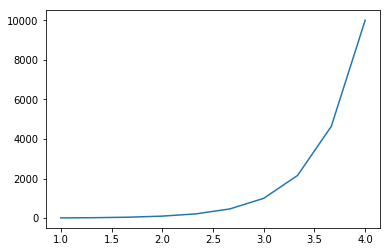

In [43]:
plt.plot(np.linspace(1, 4, 10), np.logspace(1, 4, 10))
plt.show()

In [44]:
shape = (4, 2)
print(np.zeros(shape)) # init to zero. Use np.ones or np.full accordingly

# [GOTCHA] np.empty won't initialize anything; it will just grab the first available chunk of memory
x = np.zeros(shape)
x[0] = [1, 2]
del x
print(np.empty(shape))

[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]
[[ 1.  2.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]


In [45]:
# From iterator/list/array - can just use constructor
np.array([[1, 2], range(3, 5), np.array([5, 6])]) # auto-flatten (if possible)

array([[1, 2],
       [3, 4],
       [5, 6]])

In [46]:
# Deep copies & shape/dtype preserving creations
x = np.arange(4).reshape(2, 2)
y = np.copy(x)
z = np.zeros_like(x)
x[1, 1] = 5
print(x)
print(y)
print(z)

[[0 1]
 [2 5]]
[[0 1]
 [2 3]]
[[0 0]
 [0 0]]


Extremely extensive [random generation](https://docs.scipy.org/doc/numpy/reference/routines.random.html). Remember to seed!

# Transposition

**Under the hood**. So far, we've just been looking at the abstraction that NumPy offers. How does it actually keep things contiguous in memory?

We have a base array, which is one long contiguous array from 0 to size - 1.

In [47]:
x = np.arange(2 * 3 * 4).reshape(2, 3, 4)
print(x.shape)
print(x.size)

(2, 3, 4)
24


In [48]:
# Use ravel() to get the underlying flat array. np.flatten() will give you the original
print(x)
print(x.ravel())

[[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]]

 [[12 13 14 15]
  [16 17 18 19]
  [20 21 22 23]]]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [49]:
# np.transpose or *.T will reverse axes
print('transpose', x.shape, '->', x.T.shape)
# rollaxis pulls the argument axis to axis 0, keeping all else the same.
print('rollaxis', x.shape, '->', np.rollaxis(x, 1, 0).shape)

print()
# all the above are instances of np.moveaxis
# it's clear how these behave:

perm = np.array([0, 2, 1])
moved = np.moveaxis(x, range(3), perm)

print('arbitrary permutation', list(range(3)), perm)
print(x.shape, '->', moved.shape)
print('moved[1, 2, 0]', moved[1, 2, 0], 'x[1, 0, 2]', x[1, 0, 2])

transpose (2, 3, 4) -> (4, 3, 2)
rollaxis (2, 3, 4) -> (3, 2, 4)

arbitrary permutation [0, 1, 2] [0 2 1]
(2, 3, 4) -> (2, 4, 3)
moved[1, 2, 0] 14 x[1, 0, 2] 14


In [50]:
# When is transposition useful?
# Matrix stuff, mostly:
np.random.seed(1234)

X = np.random.randn(3, 4)
print('sigma {:.2f}, eig {:.2f}'.format(
    np.linalg.svd(X)[1].max(),
    np.sqrt(np.linalg.eigvalsh(X.dot(X.T)).max())))

sigma 3.19, eig 3.19


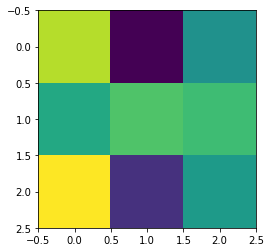

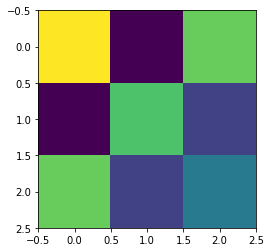

Check frob norm upper vs lower tri 0.0


In [51]:
# Create a random symmetric matrix
X = np.random.randn(3, 3)
plt.imshow(X)
plt.show()

X += X.T
plt.imshow(X)
plt.show()

print('Check frob norm upper vs lower tri', np.linalg.norm(np.triu(X) - np.tril(X).T))

In [52]:
# Row-major, C-order
# largest axis changes fastest
A = np.arange(2 * 3).reshape(2, 3).copy(order='C')

# Row-major, Fortran-order
# smallest axis changes fastest
# GOTCHA: many numpy funcitons assume C ordering
B = np.arange(2 * 3).reshape(2, 3).copy(order='F')

# Differences in representation don't manifest in abstraction
print(A)
print(B)

[[0 1 2]
 [3 4 5]]
[[0 1 2]
 [3 4 5]]


In [53]:
# Array manipulation functions with order option
# will use C/F ordering, but this is independent of the underlying layout
print(A.ravel())
print(A.ravel(order='F'))

# Reshape ravels an array, then folds back into shape, according to the given order
# Note reshape can infer one dimension; we leave it as -1.
print(A.ravel(order='F').reshape(-1, 3))
print(A.ravel(order='F').reshape(-1, 3, order='F'))

[0 1 2 3 4 5]
[0 3 1 4 2 5]
[[0 3 1]
 [4 2 5]]
[[0 1 2]
 [3 4 5]]


In [54]:
# GOTCHA: ravel will copy the array so that everything is contiguous
# if the order differs
print(id(A.base), id(A.ravel().base), id(A.ravel(order='F').base))

140675174489296 140673647644144 140675174489296


# Ufuncs and Broadcasting

[doc](https://docs.scipy.org/doc/numpy-dev/reference/ufuncs.html)

In [57]:
# A ufunc is the most common way to modify arrays

# In its simplest form, an n-ary ufunc takes in n numpy arrays
# of the same shape, and applies some standard operation to "parallel elements"

a = np.arange(6)
b = np.repeat([1, 2], 3)
print(a)
print(b)
print(a + b)
print(np.add(a, b))

[0 1 2 3 4 5]
[1 1 1 2 2 2]
[1 2 3 5 6 7]
[1 2 3 5 6 7]


In [58]:
# If any of the arguments are of lower dimension, they're prepended with 1
# Any arguments that have dimension 1 are repeated along that axis

A = np.arange(2 * 3).reshape(2, 3)
b = np.arange(2)
c = np.arange(3)
for i in ['A', 'b', 'c']:
    display(i)

A (2, 3)
[[0 1 2]
 [3 4 5]]

b (2,)
[0 1]

c (3,)
[0 1 2]



In [59]:
# On the right, broadcasting rules will automatically make the conversion
# of c, which has shape (3,) to shape (1, 3)
display('A * c')
display('c.reshape(1, 3)')
display('np.repeat(c.reshape(1, 3), 2, axis=0)')

A * c (2, 3)
[[ 0  1  4]
 [ 0  4 10]]

c.reshape(1, 3) (1, 3)
[[0 1 2]]

np.repeat(c.reshape(1, 3), 2, axis=0) (2, 3)
[[0 1 2]
 [0 1 2]]



In [60]:
display('np.diag(c)')
display('A.dot(np.diag(c))')
display('A * c')

np.diag(c) (3, 3)
[[0 0 0]
 [0 1 0]
 [0 0 2]]

A.dot(np.diag(c)) (2, 3)
[[ 0  1  4]
 [ 0  4 10]]

A * c (2, 3)
[[ 0  1  4]
 [ 0  4 10]]



In [61]:
# GOTCHA: this won't compile your code to C: it will just make a slow convenience wrapper
demo = np.frompyfunc('f({}, {})'.format, 2, 1)

In [62]:
# GOTCHA: common broadcasting mistake -- append instead of prepend
display('A')
display('b')
try:
    demo(A, b) # can't prepend to (2,) with 1 to get something compatible with (2, 3)
except ValueError as e:
    print('ValueError!')
    print(e)

A (2, 3)
[[0 1 2]
 [3 4 5]]

b (2,)
[0 1]

ValueError!
operands could not be broadcast together with shapes (2,3) (2,) 


In [63]:
# np.newaxis adds a 1 in the corresponding axis
display('b[:, np.newaxis]')
display('np.repeat(b[:, np.newaxis], 3, axis=1)')
display('demo(A, b[:, np.newaxis])')
# note broadcasting rules are invariant to order
# even if the ufunc isn't 
display('demo(b[:, np.newaxis], A)')

b[:, np.newaxis] (2, 1)
[[0]
 [1]]

np.repeat(b[:, np.newaxis], 3, axis=1) (2, 3)
[[0 0 0]
 [1 1 1]]

demo(A, b[:, np.newaxis]) (2, 3)
[['f(0, 0)' 'f(1, 0)' 'f(2, 0)']
 ['f(3, 1)' 'f(4, 1)' 'f(5, 1)']]

demo(b[:, np.newaxis], A) (2, 3)
[['f(0, 0)' 'f(0, 1)' 'f(0, 2)']
 ['f(1, 3)' 'f(1, 4)' 'f(1, 5)']]



In [64]:
# Using broadcasting, we can do cheap diagonal matrix multiplication
display('b')
display('np.diag(b)')
# without representing the full diagonal matrix.
display('b[:, np.newaxis] * A')
display('np.diag(b).dot(A)')

b (2,)
[0 1]

np.diag(b) (2, 2)
[[0 0]
 [0 1]]

b[:, np.newaxis] * A (2, 3)
[[0 0 0]
 [3 4 5]]

np.diag(b).dot(A) (2, 3)
[[0 0 0]
 [3 4 5]]



In [65]:
# (Binary) ufuncs get lots of efficient implementation stuff for free
a = np.arange(4)
b = np.arange(4, 8)
display('demo.outer(a, b)')
display('np.bitwise_or.accumulate(b)')
display('np.bitwise_or.reduce(b)') # last result of accumulate

demo.outer(a, b) (4, 4)
[['f(0, 4)' 'f(0, 5)' 'f(0, 6)' 'f(0, 7)']
 ['f(1, 4)' 'f(1, 5)' 'f(1, 6)' 'f(1, 7)']
 ['f(2, 4)' 'f(2, 5)' 'f(2, 6)' 'f(2, 7)']
 ['f(3, 4)' 'f(3, 5)' 'f(3, 6)' 'f(3, 7)']]

np.bitwise_or.accumulate(b) (4,)
[4 5 7 7]

np.bitwise_or.reduce(b) ()
7



In [66]:
def setup(): return np.arange(10 ** 6)

def manual_accum(x):
    res = np.zeros_like(x)
    for i, v in enumerate(x):
        res[i] = res[i-1] | v
        
def np_accum(x):
    np.bitwise_or.accumulate(x)
    
print('accumulation speed comparison')
compare_times(manual_accum, np_accum, setup, setup)

accumulation speed comparison
    format: mean seconds (standard error) 5 runs
    manual_accum 2.83e-01 (1.66e-02)
    np_accum     1.85e-03 (9.30e-06)
    improvement ratio 152.8


# Aliasing

You can save on allocations and copies by providing the output array to copy into.

**Aliasing** occurs when all or part of the input is repeated in the output

[Ufuncs allow aliasing](https://github.com/numpy/numpy/pull/8043)

In [67]:
# Example: generating random symmetric matrices
A = np.random.randint(0, 10, size=(3,3))
print(A)
A += A.T # this operation is WELL-DEFINED, even though A is changing
print(A)

[[3 5 0]
 [7 7 9]
 [4 0 8]]
[[ 6 12  4]
 [12 14  9]
 [ 4  9 16]]


In [68]:
# Above is sugar for
np.add(A, A, out=A)

array([[12, 24,  8],
       [24, 28, 18],
       [ 8, 18, 32]])

In [69]:
x = np.arange(10)
print(x)
np.subtract(x[:5], x[5:], x[:5])
print(x)

[0 1 2 3 4 5 6 7 8 9]
[-5 -5 -5 -5 -5  5  6  7  8  9]


**[GOTCHA]: If it's not a ufunc, aliasing is VERY BAD**: [search for "In general the rule"](https://github.com/numpy/numpy/issues/8440).

In [70]:
x = np.arange(2 * 2).reshape(2, 2)
try:
    x.dot(np.arange(2), out=x)
    # GOTCHA: some other functions won't warn you!
except ValueError as e:
    print(e)

output array is not acceptable (must have the right type, nr dimensions, and be a C-Array)


# Configuration and Hardware Acceleration

NumPy works quickly because it _can_ perform vectorization by linking to C functions that were built for **your** particular system.

**[GOTCHA] There are two different high-level ways in which NumPy uses hardware to accelerate your computations**.

### Ufunc

When you perform a built-in ufunc:
* The corresponding C function is called directly from the Python interpreter
* It is not **parallelized**
* It may be **vectorized**

In general, it is tough to check whether your code is using vectorized instructions (or, in particular, which instruction set is being used, like SSE or AVX512.

* If you installed from pip or Anaconda, you're probably not vectorized.
* If you compiled NumPy yourself (and select the correct flags), you're probably fine.
* If you're using the [Numba](http://numba.pydata.org/) JIT, then you'll be vectorized too.
* If have access to `icc` and MKL, then you can use [the Intel guide](https://software.intel.com/en-us/articles/numpyscipy-with-intel-mkl) or [Anaconda](https://docs.continuum.io/mkl-optimizations/)

### BLAS

These are optimized linear algebra routines, and are only called when you invoke operations that rely on these routines.

This won't make your vectors add faster (first, NumPy doesn't ask BLAS to nor could it, since bandwidth-limited ops are not the focus of BLAS). It will help with:
* Matrix multiplication (`np.dot`)
* Linear algebra (SVD, eigenvalues, etc) (`np.linalg`)
* Similar stuff from other libraries that accept NumPy arrays may use BLAS too.

There are different implementations for BLAS. Some are free, and some are proprietary and built for specific chips (MKL). You can check which version you're using [this way](http://stackoverflow.com/questions/9000164/how-to-check-blas-lapack-linkage-in-numpy-scipy), though you can only be sure [by inspecting the binaries manually](http://stackoverflow.com/questions/37184618/find-out-if-which-blas-library-is-used-by-numpy).

Any NumPy routine that uses **BLAS** will use, by default **ALL AVAILABLE CORES**. This is a departure from the standard parallelism of `ufunc` or other numpy transformations. You can change BLAS parallelism with the `OMP_NUM_THREADS` environment variable.

# Stuff to Avoid

NumPy has some cruft left over due to backwards compatibility. There are some edge cases when you would (maybe) use these things (but probably not). In general, avoid them:

* `np.chararray`: use an `np.ndarray` with `unicode` `dtype`
* `np.MaskedArrays`: use a boolean advanced index
* `np.matrix`: use a 2-dimensional `np.ndarray`

# Stuff Not Mentioned

* [General array manipulation](https://docs.scipy.org/doc/numpy-dev/reference/routines.array-manipulation.html)
    * Selection-related convenience methods `np.sort, np.unique`
    * Array composition and decomposition `np.split, np.stack`
    * Reductions many-to-1 `np.sum, np.prod, np.count_nonzero`
    * Many-to-many array transformations `np.fft, np.linalg.cholesky`
* [String formatting](https://docs.scipy.org/doc/numpy/reference/generated/numpy.array2string.html) `np.array2string`
* [IO](https://docs.scipy.org/doc/numpy/reference/routines.io.html#string-formatting) `np.loadtxt, np.savetxt`
* [Polynomial interpolation](https://docs.scipy.org/doc/numpy/reference/routines.polynomials.html) and related [scipy integration](https://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html)
* [Equality testing](https://docs.scipy.org/doc/numpy/reference/routines.testing.html)